# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
def check_missing_values(df):
    # Вычисляем количество пропущенных значений для каждого столбца
    missing_values = df.isnull().sum()

    # Вычисляем процент пропущенных значений для каждого столбца
    total_values = len(df)
    missing_percent = ((missing_values / total_values) * 100).round(2)

    # Создаем новый столбец "строк пропущено" и вычисляем количество строк с хотя бы одним пропущенным значением
    missing_data = pd.DataFrame({'Столбец': missing_values.index, 'Пропущено в %': missing_percent.values})
    missing_data['Строк пропущено'] = df.isnull().any(axis=1).sum()

    # Сортируем датафрейм по убыванию процента пропущенных значений
    missing_data = missing_data.sort_values(by='Пропущено в %', ascending=False)

    return missing_data

In [3]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2331,B-3513567K,Mercedes-Benz E200,business,petrol,4.66,2013,48944,2020,46.05,engine_fuel
1900,Z82302317n,Kia Rio X-line,economy,petrol,4.02,2015,84559,2016,47.50,wheel_shake
2191,P91939666m,Nissan Qashqai,standart,petrol,4.04,2014,64677,2016,34.54,gear_stick
1272,d16236969s,VW Polo VI,economy,petrol,3.80,2013,53746,2016,45.23,engine_ignition
810,N-1305225x,VW Polo VI,economy,petrol,5.36,2013,44425,2017,25.03,wheel_shake


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [4]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
667417,q67229859S,v-1386883Q,Z1j,2020-03-08,6.25,270,2696,54,74.000000,1,1049.662342,0,-16.109307,-1.583
579474,Z21223110U,p-1264204Z,V1T,2020-01-30,4.05,99,885,51,76.000000,5,2041.288848,0,-6.509730,30.342
417269,A77086439Q,d-8576748Q,u1A,2020-01-10,5.74,20,254,33,53.319367,0,592.117231,0,-6.899603,4.479
320830,r17952620W,W20898223q,w1U,2020-03-19,2.82,15,160,34,61.000000,0,547.098471,0,8.475999,55.014
288802,K15862734K,U-1810601i,P1E,2020-03-13,6.46,62,676,49,85.000000,2,843.273480,0,2.960972,-5.699


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [5]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
3336,33,7.7,506,10.0,Z19603355K,1,2019-7-5
6771,34,7.8,796,8.0,i36649527I,0,2019-4-18
433,43,7.8,770,13.0,Q20689175W,0,2019-4-24
2639,31,8.2,1344,12.0,P10435863w,1,2018-9-1
15139,34,7.9,1009,4.0,s21499193t,0,2019-2-22


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [6]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
64241,o65053979S,QX,2019-3-18 2:31,reparking,1.0,22
18442,I-1072340c,GW,2020-12-12 9:34,reparking,1.0,30
136962,J16760665u,XY,2020-11-12 12:55,repair,5.3,8
12782,D10115495S,WV,2020-1-25 9:0,refuel_check,1.0,25
143742,w-2100178z,UX,2020-10-19 15:38,repair,10.0,61


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## 1.Возьмите датасет rides_info с информацией о поездках и проведите группировку по каждой машине отдельно.
## 2.Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:
- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

In [7]:
# Группировка по каждой машине и расчет статистик
grouped_rides = rides_info.groupby('car_id').agg(
    
    min_rating=('rating', 'min'),
    avg_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count')
).reset_index()

grouped_rides.head(1)

,car_id,min_rating,avg_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174


## 3. Добавьте минимум 3 признака на свой выбор

In [8]:
# 1. Расчет частоты остановок и стартов на 100 км
rides_info['stops_per_100km'] = (rides_info['stop_times'] / rides_info['distance']) * 100

# 2. Расчет процента поездок с превышением средней скорости выше 45 км/ч
rides_info['speed_over_45'] = rides_info['speed_avg'] > 45
percentage_over_45 = rides_info.groupby('car_id')['speed_over_45'].mean() * 100

# 3. Среднее отклонение скорости от средней по автопарку
avg_speed_overall = rides_info['speed_avg'].mean()
rides_info['speed_deviation_from_avg'] = abs(rides_info['speed_avg'] - avg_speed_overall)
avg_speed_deviation_per_car = rides_info.groupby('car_id')['speed_deviation_from_avg'].mean()

# Объединение новых признаков с уже существующими данными
new_features = pd.DataFrame({
    'car_id': rides_info['car_id'].unique(),
    'stops_per_100km': rides_info.groupby('car_id')['stops_per_100km'].mean(),
    'percentage_speed_over_45': percentage_over_45,
    'avg_speed_deviation_from_avg': avg_speed_deviation_per_car
}).reset_index(drop=True)

grouped_rides = pd.merge(grouped_rides, new_features, on='car_id', how='left')

# Дополнительные признаки
additional_features = rides_info.groupby('car_id').agg(
    avg_stop_times=('stop_times', 'mean'),
    avg_deviation_normal=('deviation_normal', 'mean')
).reset_index()

# Объединение дополнительных признаков с уже существующими данными
enhanced_grouped_rides = pd.merge(grouped_rides, additional_features, on='car_id', how='left')

# Вывод первой строки обновленного DataFrame для проверки
enhanced_grouped_rides.head(1)

,car_id,min_rating,avg_rating,total_distance,max_speed,total_rides,stops_per_100km,percentage_speed_over_45,avg_speed_deviation_from_avg,avg_stop_times,avg_deviation_normal
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,0.118979,51.724138,11.85128,0.816092,-6.136672


- Частота остановок и стартов на 100 км `stops_per_100km`. Показывает, сколько раз в среднем автомобиль останавливается и снова начинает движение на каждые 100 км пройденного пути. Это может помочь выявить потенциальный износ тормозной системы и двигателя.

- Процент поездок с превышением средней скорости выше 45 км/ч `percentage_speed_over_45`. Отражает долю поездок, во время которых средняя скорость превышала 45 км/ч. Этот признак может указывать на агрессивное вождение, что увеличивает риск износа и поломок.

-  Среднее отклонение скорости от средней по автопарку `avg_speed_deviation_from_avg`. Представляет собой среднее абсолютное отклонение средней скорости каждого автомобиля от средней скорости по всему автопарку. Это может помочь выявить автомобили, чья эксплуатация значительно отличается от средней, что потенциально может свидетельствовать о повышенном риске износа или поломок.

- Среднее количество остановок на поездку `avg_stop_times`. Это может указывать на стиль вождения или типы маршрутов, которые выбирает водитель.

- Среднее отклонение от нормы `avg_deviation_normal`.

# 4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

In [9]:
# Используем merge для соединения car_train и enhanced_grouped_rides по car_id
full_car_info = pd.merge(car_train, enhanced_grouped_rides, on='car_id', how='left')

full_car_info.head(1)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,avg_rating,total_distance,max_speed,total_rides,stops_per_100km,percentage_speed_over_45,avg_speed_deviation_from_avg,avg_stop_times,avg_deviation_normal
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,174,0.287586,45.402299,8.088746,3.62069,-0.120391


## 5.Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info).  Добавьте минимум 3 любых признака с каждого датасета

Я буду использовать метод merge() для объединения датасетов по соответствующим ключам. 


In [10]:
# Присоединяем rides_info к full_car_info по car_id
full_car_rides = pd.merge(full_car_info, rides_info, on='car_id', how='left')

# Присоединяем driver_info к full_car_rides по user_id
full_car_drivers = pd.merge(full_car_rides, driver_info[['user_id', 'age', 'user_rating', 'user_time_accident']], on='user_id', how='left')

# Присоединяем fix_info к full_car_drivers по car_id, выбирая нужные столбцы
final_df = pd.merge(full_car_drivers, fix_info[['car_id', 'fix_date', 'work_type', 'destroy_degree']], on='car_id', how='left', suffixes=('', '_fix'))

final_df.head(1)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,deviation_normal,stops_per_100km_y,speed_over_45,speed_deviation_from_avg,age,user_rating,user_time_accident,fix_date,work_type,destroy_degree
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.0,0.3566,False,5.01227,38,7.4,2.0,2019-8-10 9:29,reparking,1.0


In [11]:
# Используем функцию для анализа датафрейма train_df_cleaned
missing_data_summary_5 = check_missing_values(final_df)
missing_data_summary_5

,Столбец,Пропущено в %,Строк пропущено
38,user_time_accident,13.17,1943425
27,speed_max,0.45,1943425
31,user_ride_quality,0.37,1943425
0,car_id,0.00,1943425
23,rating,0.00,1943425
24,ride_duration,0.00,1943425
25,ride_cost,0.00,1943425
26,speed_avg,0.00,1943425
28,stop_times,0.00,1943425
29,distance,0.00,1943425


Метод был выбран с учётом необходимости объединения информации из различных источников для получения полной картины состояния автопарка, включая характеристики водителей и историю обслуживания каждого автомобиля. В данном случае, ключевой элемент связи — `rides_info`, который позволяет связать информацию о водителях `driver_info` и информацию о ремонтах `fix_info` с конкретными автомобилями `full_car_info` через поездки. Выбор такого подхода направлен на создание основы для комплексного анализа, который может включать изучение взаимосвязи между характеристиками водителя и состоянием автомобиля, анализ влияния ремонтов на общую оценку автомобилей, и др. аспекты, важные для управления автопарком и повышения качества обслуживания клиентов.

Из `driver_info` выбраны колонки: `age`, `user_rating`, `sex`

- `age`: Возраст водителя может быть важным фактором, влияющим на стиль вождения, опыт и, потенциально, на безопасность поездок.
- `user_rating`: Рейтинг водителя напрямую отражает удовлетворенность клиентов услугами водителя. Это ключевой показатель качества сервиса.
- `sex`: Предполагаю, что пол водителя включён в анализ, возможно, для исследования статистических различий в показателях вождения или предпочтениях клиентов.

Из `fix_info`выбраны колонки: `fix_date`, `work_type`, `destroy_degree`

`fix_date`: Дата последнего ремонта может помочь оценить текущее техническое состояние автомобиля и планировать будущее обслуживание.
`work_type`: Тип проведённых работ дает понимание о характере вмешательства в автомобиль, будь то регулярное техобслуживание или устранение неисправности.
`destroy_degree`: Степень повреждения автомобиля при последнем ремонте может указывать на серьёзность происшествий или износа, с которыми автомобиль сталкивался в прошлом.

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [12]:
#!pip install catboost shap -q

In [12]:
# Сразу дропаем 
# - константы;
# - уникальные значения (в том числе в тесте; как правило, это ID-шники по типу car_id).

## Определение столбцов с константными значениями
constant_columns = [col for col in final_df.columns if final_df[col].nunique() == 1]

# Определение столбцов с уникальными значениями (исключая NaN)
unique_value_columns = [col for col in final_df.columns if final_df[col].nunique() == final_df.shape[0]]

# Уникальные значения
id_columns = ['user_id', 'car_id', 'ride_id']

# Объединение списков столбцов для удаления
columns_to_drop = list(set(constant_columns + unique_value_columns + id_columns))

# Удаление столбцов из final_df
final_df_cleaned = final_df.drop(columns=columns_to_drop)

print(f"Удалены столбцы: {columns_to_drop}")

pd.set_option('display.max_columns', None)
final_df_cleaned.head(1)

Удалены столбцы: ['user_id', 'ride_id', 'car_id', 'total_rides']


,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,avg_rating,total_distance,max_speed,stops_per_100km_x,percentage_speed_over_45,avg_speed_deviation_from_avg,avg_stop_times,avg_deviation_normal,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,stops_per_100km_y,speed_over_45,speed_deviation_from_avg,age,user_rating,user_time_accident,fix_date,work_type,destroy_degree
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,0.287586,45.402299,8.088746,3.62069,-0.120391,2020-01-01,5.72,220,3514,42,NaN,6,1682.556402,0,0.52475,0.0,0.3566,False,5.01227,38,7.4,2.0,2019-8-10 9:29,reparking,1.0


Датасет весьма большой и чтобы начать оптимизировать компьют, изначально переведу типы данных из 64 разрядных в 32 разрядные. Для этого напишу функцию `convert_dtypes`.

In [13]:
def convert_dtypes(final_df_cleaned):
    """
    Преобразует типы данных столбцов в датасете final_df_cleaned:
    int64 в int32 и float64 в float32.

    Параметры:
    final_df_cleaned (pd.DataFrame): Исходный датасет для преобразования.

    Возвращает:
    pd.DataFrame: Датасет с преобразованными типами данных.
    """
    for column in final_df_cleaned.columns:
        if final_df_cleaned[column].dtype == 'int64':
            final_df_cleaned[column] = final_df_cleaned[column].astype('int32')
        elif final_df_cleaned[column].dtype == 'float64':
            final_df_cleaned[column] = final_df_cleaned[column].astype('float32')
    
    return final_df_cleaned

final_df_cleaned = convert_dtypes(final_df_cleaned)

In [14]:
final_df_cleaned.shape

(13970460, 38)

Почти 14 миллионов наблюдений, это очень много. Для того чтобы продолжить выполнение задания, оптимизируем процесс и сократим выборку до 20% от первоначальой выборки.

In [15]:
sampled_df = final_df_cleaned.sample(frac=0.1, random_state=42)
sampled_df.shape

(1397046, 38)

Осталось почти 3 миллиона наблюдений, все еще много, но думается, с таким набором шансов на успешный feature importance повышаются :)

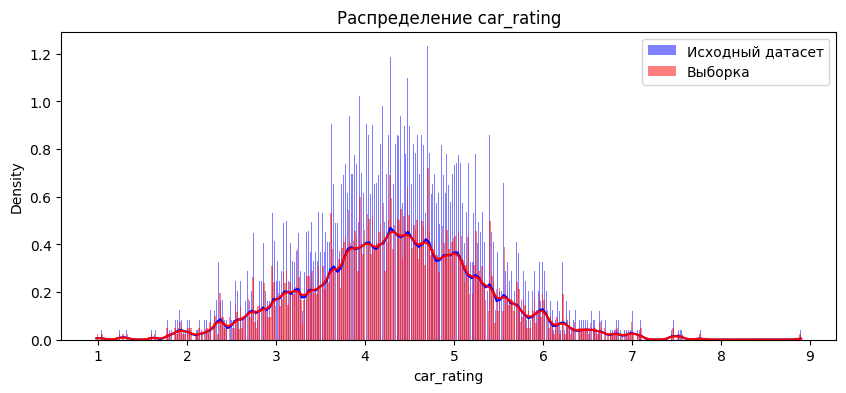

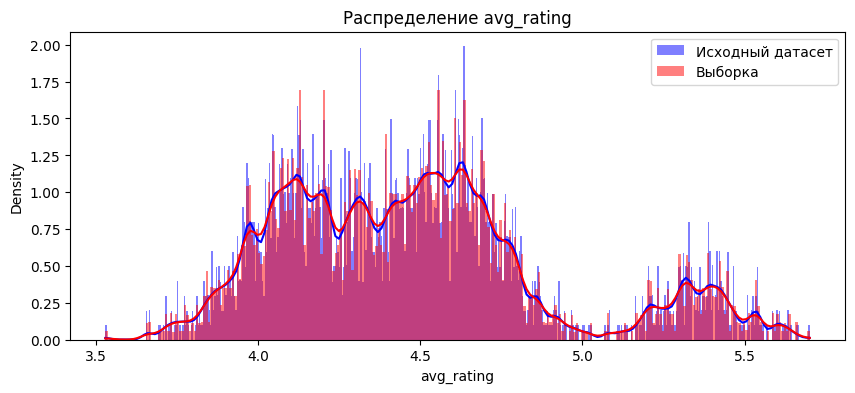

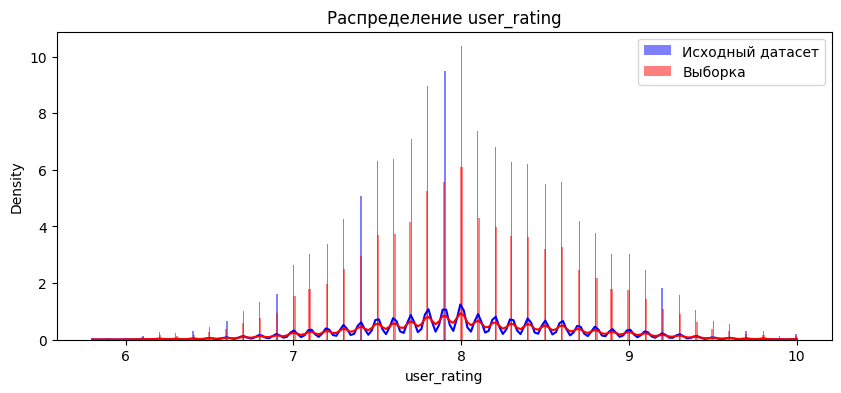

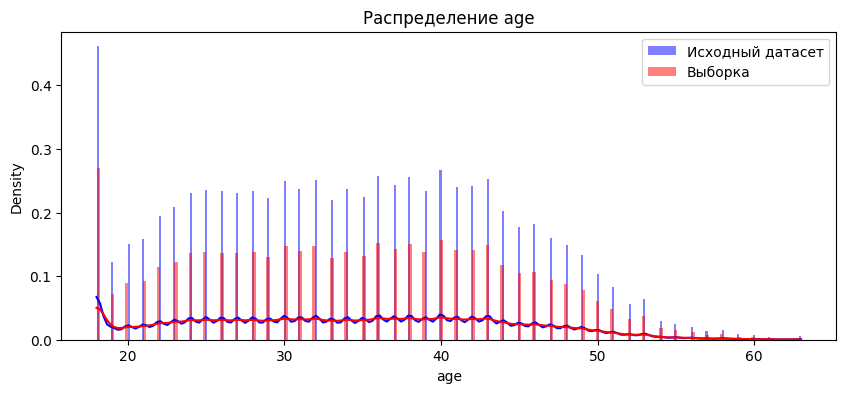

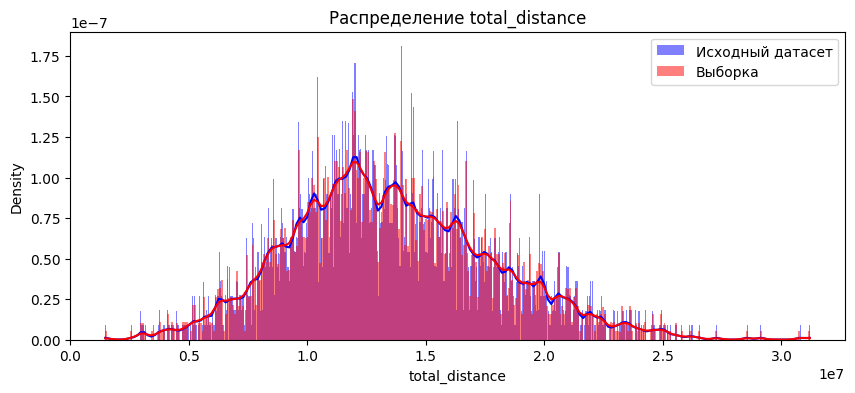

In [17]:
# Посмотрим на репрезентативность нашей выборки, на основании следующих переменных
variables = ['car_rating', 'avg_rating', 'user_rating', 'age', 'total_distance']

for var in variables:
    plt.figure(figsize=(10, 4))
    sns.histplot(final_df_cleaned[var], color="blue", label="Исходный датасет", kde=True, stat="density", linewidth=0)
    sns.histplot(sampled_df[var], color="red", label="Выборка", kde=True, stat="density", linewidth=0, alpha=0.5)
    plt.legend()
    plt.title(f'Распределение {var}')
    plt.show()

Проведем t-test

In [18]:
from scipy.stats import ttest_ind

# Для каждой ключевой переменной выполним t-тест
results = []
for var in variables:
    stat, p = ttest_ind(final_df_cleaned[var], sampled_df[var])
    results.append((var, stat, p))

# Выведем результаты
print("Переменная\tСтатистика t\tP-value")
for res in results:
    print(f"{res[0]}\t{res[1]:.2f}\t{res[2]:.3f}")

Переменная	Статистика t	P-value
car_rating	-1.41	0.157
avg_rating	1.15	0.248
user_rating	-0.38	0.701
age	-1.91	0.056
total_distance	0.51	0.607


In [16]:
sampled_df = sampled_df.drop('target_reg', axis = 1)

На первый взгляд выборка выглядит весьма не плохо, переходим к следующему пункту

### Способ № 1 Feature importance (CatBoost)

In [17]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Подготовка данных
X = sampled_df.drop(['target_class'], axis=1, errors='ignore')  # Удаляем только целевую переменную
y = sampled_df['target_class'].fillna(0)

# Категориальные колонки
cat_features = ['model', 'car_type', 'fuel_type', 'ride_date', 'fix_date', 'work_type']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Создание объектов Pool
pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_test, y_test, cat_features=cat_features)

# Инициализация и обучение модели CatBoost
model_2 = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=10,
    cat_features=cat_features,
    verbose=100,
    early_stopping_rounds=100,
    task_type="GPU",
    random_seed=42
)

model_2.fit(pool_train, eval_set=pool_test, use_best_model=True)

# Вывод важности признаков
feature_importances = model_2.get_feature_importance()
importance_df = pd.DataFrame(feature_importances, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)
importance_df

0:	learn: 1.5721788	test: 1.5722101	best: 1.5722101 (0)	total: 69.4ms	remaining: 6.87s
99:	learn: 0.0182739	test: 0.0178714	best: 0.0178714 (99)	total: 6.57s	remaining: 0us
bestTest = 0.01787139782
bestIteration = 99


,Importance
avg_stop_times,29.820664
max_speed,15.977289
avg_rating,8.767209
min_rating,7.034925
avg_speed_deviation_from_avg,5.984213
fix_date,3.621881
stops_per_100km_x,3.281100
avg_deviation_normal,3.175169
car_rating,3.054938
destroy_degree,2.905209


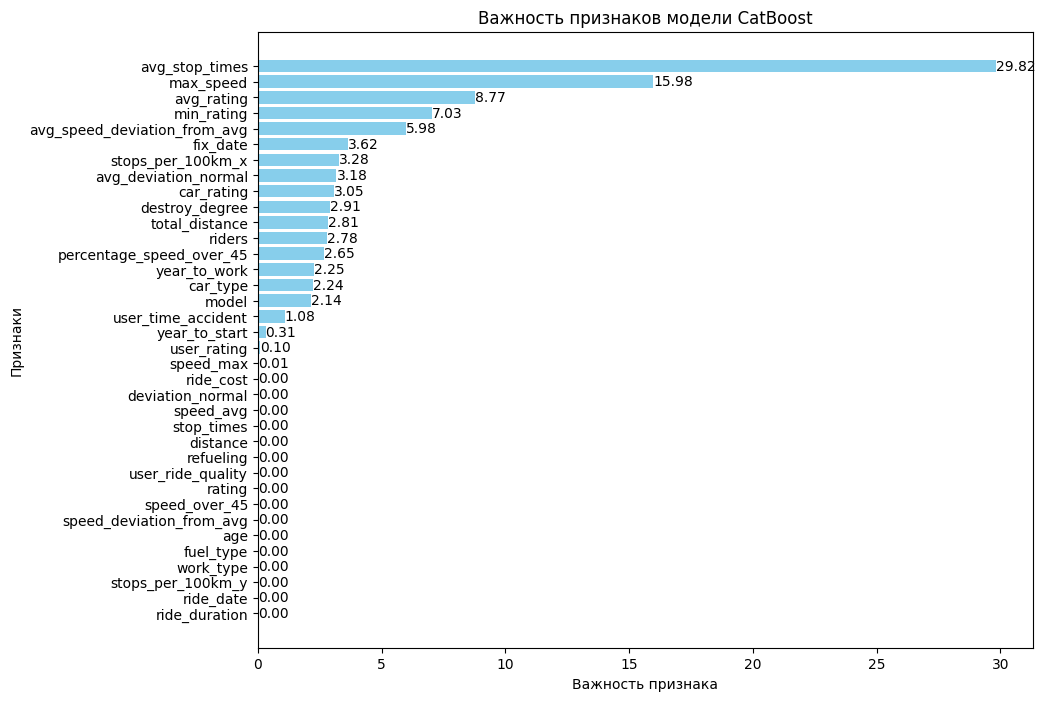

In [19]:
# Сортировка значений важности признаков по убыванию
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=True)

# Создание горизонтальной столбчатой диаграммы
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df_sorted.index, importance_df_sorted['Importance'], color='skyblue')

# Добавление значений на диаграмме
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", 
             va='center', ha='left')

plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.show()

### Способ № 2 Phink

In [23]:
# !pip install phik -q

In [24]:
# import phik
# from phik import resources, report
# import seaborn as sns

# # Вычисляем корреляцию Phik 
# phik_matrix = final_df_cleaned.phik_matrix()

# # Отображение корреляционной матрицы Phik
# print(phik_matrix)

# # Визуализация корреляционной матрицы 
# plt.figure(figsize=(12, 10))
# sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")
# plt.title("Phik Correlation Matrix")
# plt.show()

‪![ошибка](1.jpg)
Способ мне не понравился, т.к., на мой взгляд, он пораждает различного рода проблемы, основной из которых является необходимость решить что-то с колонкой `fix_date`. Самым разумным представляется использовать какие-то конкретные данные из нее, например день или время поломки, а не всю дату целиком. Можно еще и дропнуть ее, но в таком случае, мы можем потерять потенциальный признак, который может быть важным для нашего анализа. Чтобы выполнить задание и не терять время, я дропнул эту колонку, но на самом деле, не будь это частью задания и будь у меня больше времени на исследование, я бы так не поступил!

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'stops_per_100km_x', 'percentage_speed_over_45', 'avg_speed_deviation_from_avg', 'avg_stop_times', 'avg_deviation_normal', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'stops_per_100km_y', 'speed_deviation_from_avg', 'age', 'user_rating', 'user_time_accident', 'destroy_degree']
                                 model  car_type  fuel_type  car_rating  \
model                         1.000000  1.000000   1.000000    0.249061   
car_type                      1.000000  1.000000   0.695130    0.090482   
fuel_type                     1.000000  0.695130   1.000000    0.073845   
car_rating                    0.249061  0.090482   0.073845    1.000000   
year_to_start                 0.578175  0.280981   0.024764    0.132327   
riders           

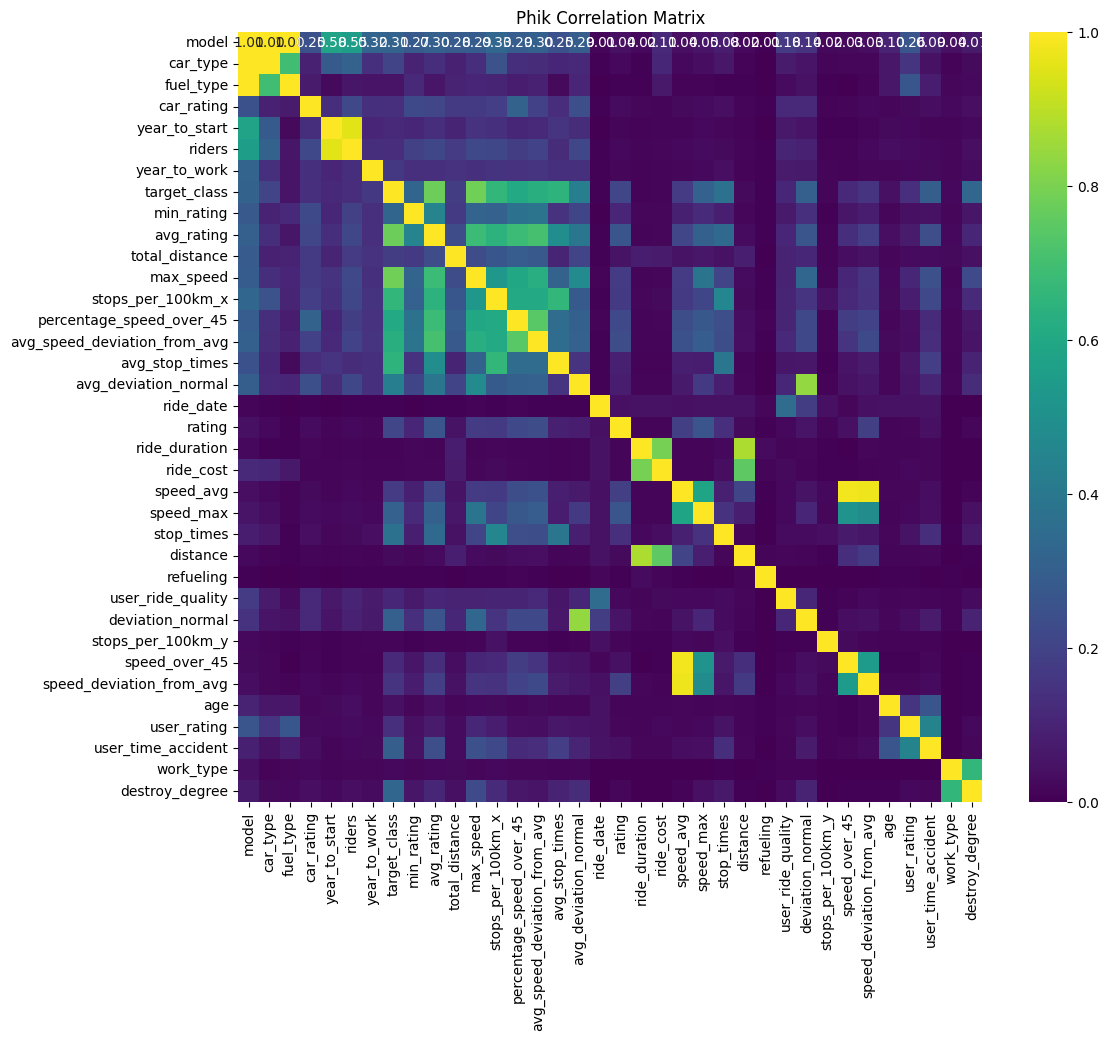

In [25]:
import phik
from phik import resources, report
import seaborn as sns

# Дропаю 'fix_date'
sampled_df = sampled_df.drop(columns=['fix_date'])

# Вычисляем корреляцию Phik 
phik_matrix = sampled_df.phik_matrix()

# Отображение корреляционной матрицы Phik
print(phik_matrix)

# Визуализация корреляционной матрицы 
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Phik Correlation Matrix")
plt.show()

### Способ № 3 Permutation Importance

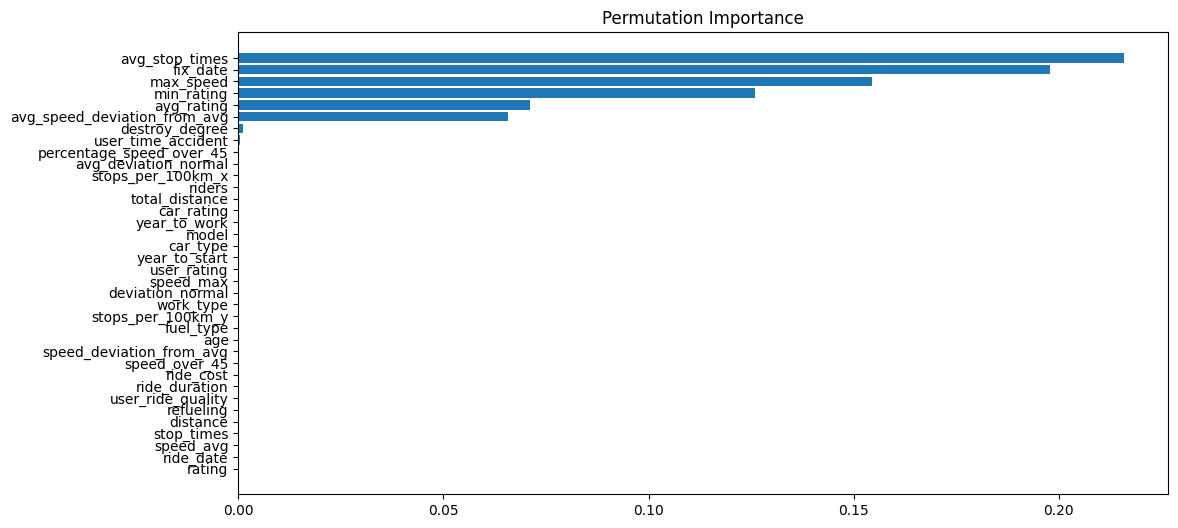

In [26]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [27]:
# Получаем топ-10 признаков от CatBoostClassifier
top_features_catboost = importance_df.head(10).index.tolist()

# Для Phik: предполагая, что у вас есть переменная phik_matrix
top_features_phik = phik_matrix['target_class'].abs().sort_values(ascending=False).head(11).index.tolist()
top_features_phik.remove('target_class')  # Удаляем целевую переменную из списка

# Для Permutation Importance
perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_features_permutation = X.columns[perm_sorted_idx][:10].tolist()

# Создание DataFrame для сводной таблицы
summary_df = pd.DataFrame({
    'CatBoost': top_features_catboost,
    'Phik': top_features_phik,
    'Permutation': top_features_permutation
})

summary_df

,CatBoost,Phik,Permutation
0,fix_date,max_speed,avg_stop_times
1,max_speed,avg_rating,fix_date
2,avg_stop_times,stops_per_100km_x,max_speed
3,avg_rating,avg_stop_times,min_rating
4,min_rating,avg_speed_deviation_from_avg,avg_rating
5,avg_speed_deviation_from_avg,percentage_speed_over_45,avg_speed_deviation_from_avg
6,destroy_degree,avg_deviation_normal,destroy_degree
7,percentage_speed_over_45,stop_times,user_time_accident
8,stops_per_100km_x,destroy_degree,percentage_speed_over_45
9,user_time_accident,min_rating,avg_deviation_normal


In [28]:
# Преобразуем списки в множества для удобства операций
set_catboost = set(top_features_catboost)
set_permutation = set(top_features_permutation)

# Признаки, присутствующие и в CatBoost, и в Permutation
common_features = set_catboost.intersection(set_permutation)

# Признаки, присутствующие в CatBoost, но отсутствующие в Permutation
unique_to_catboost = set_catboost.difference(set_permutation)

# Признаки, присутствующие в Permutation, но отсутствующие в CatBoost
unique_to_permutation = set_permutation.difference(set_catboost)

print("Признаки, присутствующие и в CatBoost, и в Permutation Importance:")
for feature in common_features:
    print(feature)

print("\nПризнаки, присутствующие в CatBoost, но отсутствующие в Permutation Importance:")
for feature in unique_to_catboost:
    print(feature)
    
print("\nПризнаки, присутствующие в Permutation, но отсутствующие в CatBoost:")
for feature in unique_to_permutation:
    print(feature)

Признаки, присутствующие и в CatBoost, и в Permutation Importance:
avg_stop_times
fix_date
user_time_accident
min_rating
max_speed
percentage_speed_over_45
avg_rating
avg_speed_deviation_from_avg
destroy_degree

Признаки, присутствующие в CatBoost, но отсутствующие в Permutation Importance:
stops_per_100km_x

Признаки, присутствующие в Permutation, но отсутствующие в CatBoost:
avg_deviation_normal


In [29]:
# import shap
# # Создание объекта TreeExplainer 
# explainer = shap.TreeExplainer(model)

# # Вычисление SHAP values
# shap_values = explainer.shap_values(pool_test)

# # Визуализация средней абсолютной величины значений SHAP для каждого признака
# shap.summary_plot(shap_values, X_test, max_display=25)

**Вывод**: На мой взгляд, лучше всего показал себя метод с Catboost feature importance. Он более прост в использовании, не нужна и устойчив к различному типу данных. Также более наглядный и показательный, по моему мнению. 

- Наиболее значимыми признаками для модели, согласно полученным значениям важности признаков, являются target_class, avg_stop_times, total_distance, car_rating, и avg_deviation_normal. Эти признаки оказывают наибольшее влияние на прогнозируемую переменную, что указывает на их потенциальную релевантность и важность в контексте нашей задачи.

- Матрица корреляции Phik показывает взаимосвязи между различными признаками и целевой переменной. Например, признаки model, car_type, и fuel_type имеют высокие значения корреляции друг с другом, что может указывать на наличие мультиколлинеарности. Важно отметить, что Phik корреляция адаптирована для работы как с числовыми, так и с категориальными данными, предоставляя более широкий анализ взаимосвязей.

- Наличие высоких корреляций между некоторыми признаками, например между model, car_type, и fuel_type, может указывать на мультиколлинеарность, которая потенциально может влиять на стабильность и интерпретируемость модели. Возможно, стоит рассмотреть исключение или комбинацию некоторых из этих признаков для улучшения качества модели.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

Для начала заполним пропуски. На данный момент заполню пропуски средними значениями по столбцу. В связи с тем, что наш датафрейм большой, будем использовать библиотеку dask для обработки пропусков.

In [17]:
from tqdm.auto import tqdm
import dask.dataframe as dd

In [18]:
# Создание Dask DataFrame из Pandas DataFrame
dask_df = dd.from_pandas(final_df_cleaned, npartitions=10)

# Вычисление средних значений только для числовых столбцов
means = dask_df.select_dtypes(include=['number']).mean().compute()

# Применение fillna к каждому числовому столбцу отдельно
for column in tqdm(dask_df.select_dtypes(include=['number']).columns, desc="Filling missing values"):
    dask_df[column] = dask_df[column].fillna(means[column])
final_df_cleaned = dask_df.compute()

Filling missing values:   0%|          | 0/30 [00:00<?, ?it/s]

In [19]:
# Используем функцию для анализа датафрейма train_df_cleaned
missing_data_summary_6 = check_missing_values(sampled_df)
missing_data_summary_6

,Столбец,Пропущено в %,Строк пропущено
33,user_time_accident,13.20,194761
22,speed_max,0.45,194761
26,user_ride_quality,0.37,194761
0,model,0.00,194761
27,deviation_normal,0.00,194761
21,speed_avg,0.00,194761
23,stop_times,0.00,194761
24,distance,0.00,194761
25,refueling,0.00,194761
28,stops_per_100km_y,0.00,194761


## 1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

In [20]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [21]:
# Выбор столбцов типа 'object' и 'category'
categorical_columns = final_df_cleaned.select_dtypes(include=['object', 'category']).columns
# Выбор столбцов числовых типов
numeric_columns = final_df_cleaned.select_dtypes(include=['number']).columns

# Выбор столбцов типа 'object' и 'category', исключая 'target_class'
categorical_columns = final_df_cleaned.select_dtypes(include=['object', 'category']).columns
categorical_columns = categorical_columns.drop('target_class')  

# Выбор столбцов числовых типов, исключая 'target_reg'
numeric_columns = final_df_cleaned.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('target_reg')  #

# Вывод названий категориальных столбцов
print(f'Категориальные признаки: {categorical_columns}')
print('---'*35)
# Вывод названий числовых столбцов
print(f'Числовые признаки: {numeric_columns}')

Категориальные признаки: Index(['model', 'car_type', 'fuel_type', 'ride_date', 'fix_date', 'work_type'], dtype='object')
---------------------------------------------------------------------------------------------------------
Числовые признаки: Index(['car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'stops_per_100km_x',
       'percentage_speed_over_45', 'avg_speed_deviation_from_avg',
       'avg_stop_times', 'avg_deviation_normal', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal',
       'stops_per_100km_y', 'speed_deviation_from_avg', 'age', 'user_rating',
       'user_time_accident', 'destroy_degree'],
      dtype='object')


In [22]:
features2drop = ['riders', 'rating', 'speed_avg', 'ride_cost', 'stop_times', 'speed_over_45',
                 'stops_per_100km_y', 'speed_deviation_from_avg', 'age', 'user_rating', 'work_type'] # то, что надо выбросить
targets = ['target_class'] # таргеты 'target_reg'
cat_features = ['model', 'car_type', 'fuel_type', 'ride_date', 'fix_date'] # категориальные признаки

num_features = ['car_rating', 'year_to_start', 'year_to_work', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'stops_per_100km_x',
       'percentage_speed_over_45', 'avg_speed_deviation_from_avg',
       'avg_stop_times', 'avg_deviation_normal', 'ride_duration',
       'speed_max', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal',
       'user_time_accident', 'destroy_degree'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('***'*35)
print('Числовые признаки:', len(num_features), num_features)
print('***'*35)
print('Целевые переменные', targets)

Категориальные признаки: 5 ['model', 'car_type', 'fuel_type', 'ride_date', 'fix_date']
*********************************************************************************************************
Числовые признаки: 20 ['car_rating', 'year_to_start', 'year_to_work', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'stops_per_100km_x', 'percentage_speed_over_45', 'avg_speed_deviation_from_avg', 'avg_stop_times', 'avg_deviation_normal', 'ride_duration', 'speed_max', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'user_time_accident', 'destroy_degree']
*********************************************************************************************************
Целевые переменные ['target_class']


In [23]:
# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in final_df_cleaned.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]
print("cat_features", cat_features)
print("num_features", num_features)
print("targets", targets)

cat_features ['model', 'car_type', 'fuel_type', 'ride_date', 'fix_date']
num_features ['car_rating', 'year_to_start', 'year_to_work', 'target_reg', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'stops_per_100km_x', 'percentage_speed_over_45', 'avg_speed_deviation_from_avg', 'avg_stop_times', 'avg_deviation_normal', 'ride_duration', 'speed_max', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'user_time_accident', 'destroy_degree']
targets ['target_class']


In [24]:
for c in cat_features:  # Избавлеямся от NaN'ов
    final_df_cleaned[c] = final_df_cleaned[c].astype(str)

## 2. Выделите в X только признаки, а в Y — таргет (для задачи классификации).
## 3. Сделайте разделение данных на обучающую и валидационную выборки (не забывайте про воспроизводимость результатов).

In [25]:
from sklearn.model_selection import train_test_split

# Наши фичи
X = final_df_cleaned[filtered_features]
# Наш таргет (целевая переменная)
y = final_df_cleaned["target_class"]

# Деление на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Создайте и обучите CatBoostClassifier модель (настраивать гиперпараметры сейчас не обязательно).

In [26]:
from catboost import CatBoostClassifier

# Инициализация модели CatBoostClassifier для мультиклассовой классификации
model = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.1, 
    depth=4, 
    loss_function='MultiClass',
    custom_metric=['Accuracy'],
    random_seed=42, 
    cat_features=cat_features,  # Указываем категориальные признаки
    early_stopping_rounds=10,
    task_type="GPU",
    verbose=10
)

# Обучение модели
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    plot=True # по сути тоже самое что и график ниже, только встроенный в catboost
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7945626	test: 1.7946845	best: 1.7946845 (0)	total: 396ms	remaining: 39.2s
99:	learn: 0.1172568	test: 0.1175113	best: 0.1175113 (99)	total: 19.4s	remaining: 0us
bestTest = 0.1175112971
bestIteration = 99


## 5. Проведите оценку вашей модели, используя метрику accuracy.

In [27]:
# Оценка качества модели на тестовой выборке
acc = model.score(X_test, y_test)
print(f'Точность модели (accuracy) на тестовой выборке: {acc}')

Точность модели (accuracy) на тестовой выборке: 0.9637510146408923


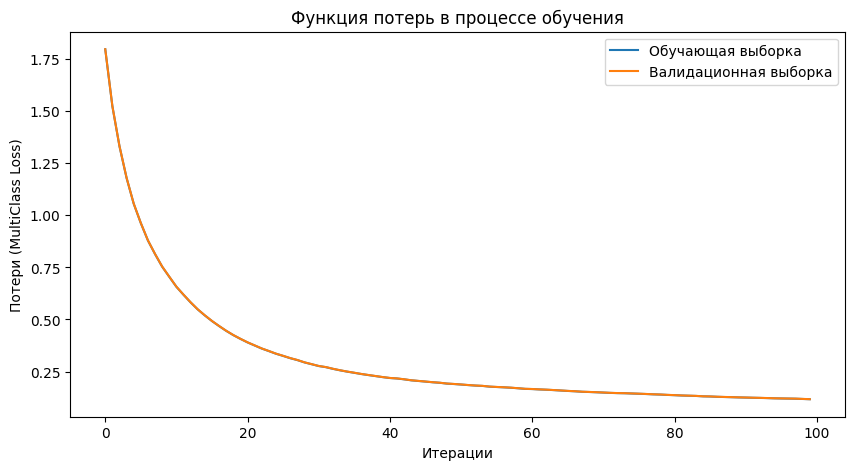

In [28]:
# Получение результатов обучения
results = model.get_evals_result()

# Визуализация кривых обучения для тренировочного и валидационного набора данных
plt.figure(figsize=(10, 5))
plt.plot(results['learn']['MultiClass'], label='Обучающая выборка')
plt.plot(results['validation']['MultiClass'], label='Валидационная выборка')

plt.title('Функция потерь в процессе обучения')
plt.xlabel('Итерации')
plt.ylabel('Потери (MultiClass Loss)')
plt.legend()
plt.show()

### Вывод:
Accuracy = 96% свидетельствует о том, что модель получилась весьма хорошей. Попробуем еще улучшить наш предикт в следующем задании, когда будем подбирать гипперпараметры. О хорошем обучении и отсутствии переобучения также свидетельствует и график функции потерь, который идет на постоянное снижение.

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

## 1. Визуализируйте важность признаков встроенным методом в CatBoost (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

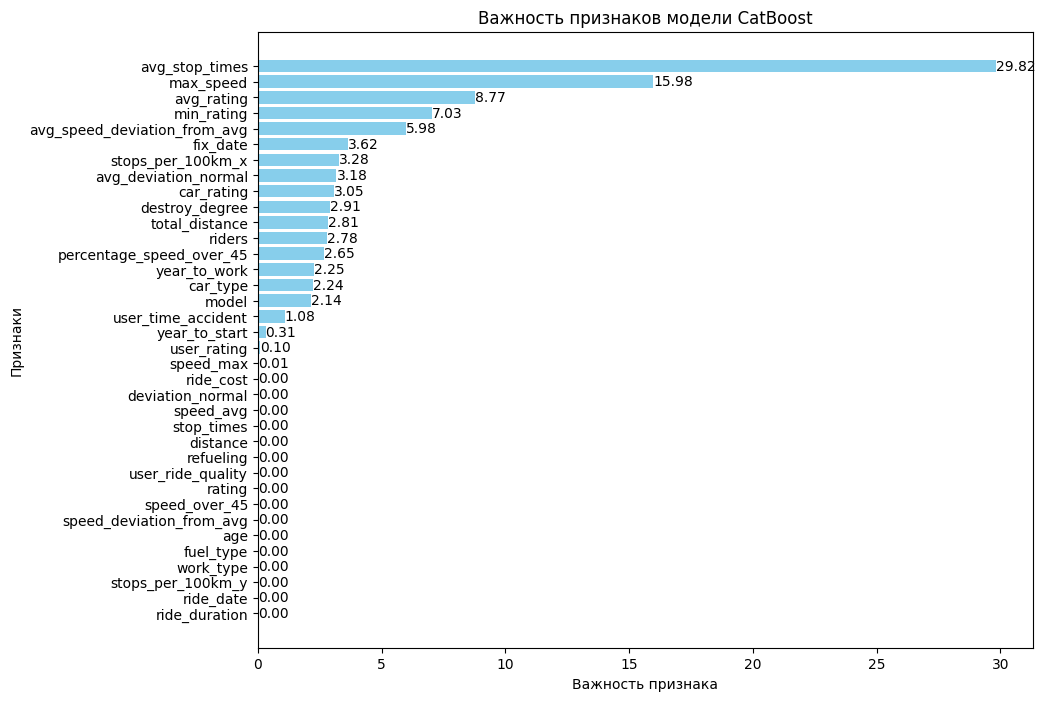

In [19]:
# Сортировка значений важности признаков по убыванию
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=True)

# Создание горизонтальной столбчатой диаграммы
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df_sorted.index, importance_df_sorted['Importance'], color='skyblue')

# Добавление значений на диаграмме
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", 
             va='center', ha='left')

plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.show()

## 2. Постройте waterfall_plot из библиотеки SHAP (подробнее во втором ноутбуке из полезных ссылок ниже).

In [27]:
# !pip install catboost -q
# # !pip uninstall opencv-python -y -q
# !pip install opencv-python shap -q

In [29]:
import shap
shap.initjs()

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Определение категориальных и целевых переменных
cat_features = ['model', 'car_type', 'fuel_type', 'ride_date', 'fix_date', 'work_type']
target = 'target_class'

# Подготовка данных
X = sampled_df.drop([target], axis=1)
y = sampled_df[target].fillna(0)

# Преобразование категориальных признаков с использованием Label Encoding
for feature in cat_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))

# Преобразование целевой переменной, если она не числовая
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Преобразование булевого признака в числовой (0 и 1)
X_train['speed_over_45'] = X_train['speed_over_45'].astype(int)
X_test['speed_over_45'] = X_test['speed_over_45'].astype(int)

In [20]:
# Подсчет количества уникальных классов в целевой переменной
num_classes = np.unique(y_train).shape[0]

# Инициализация модели XGBClassifier для мультиклассовой классификации
model_2 = XGBClassifier(
    objective='multi:softprob',  # Цель для мультиклассовой классификации
    num_class=num_classes,       # Количество классов
    random_state=42,             # Задаем seed для воспроизводимости
    use_label_encoder=False,     # Отключаем предупреждение об использовании устаревшего label encoder
    eval_metric='mlogloss'       # Метрика для оценки качества модели при мультиклассовой классификации
)

model_2.fit(
    X_train.values,  # Преобразуем DataFrame в numpy.ndarray
    y_train,
    eval_set=[(X_test.values, y_test)],  # Тестовая выборка для оценки качества модели
    early_stopping_rounds=10  # Ранняя остановка для предотвращения переобучения
)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-mlogloss:1.16276
[1]	validation_0-mlogloss:0.85125
[2]	validation_0-mlogloss:0.65657
[3]	validation_0-mlogloss:0.52502
[4]	validation_0-mlogloss:0.43057
[5]	validation_0-mlogloss:0.36001
[6]	validation_0-mlogloss:0.30697
[7]	validation_0-mlogloss:0.26666
[8]	validation_0-mlogloss:0.23606
[9]	validation_0-mlogloss:0.21153
[10]	validation_0-mlogloss:0.19252
[11]	validation_0-mlogloss:0.17728
[12]	validation_0-mlogloss:0.16308
[13]	validation_0-mlogloss:0.15029
[14]	validation_0-mlogloss:0.13990
[15]	validation_0-mlogloss:0.13142
[16]	validation_0-mlogloss:0.12284
[17]	validation_0-mlogloss:0.11346
[18]	validation_0-mlogloss:0.10665
[19]	validation_0-mlogloss:0.09788
[20]	validation_0-mlogloss:0.09014
[21]	validation_0-mlogloss:0.08426
[22]	validation_0-mlogloss:0.07797
[23]	validation_0-mlogloss:0.07099
[24]	validation_0-mlogloss:0.06526
[25]	validation_0-mlogloss:0.06146
[26]	validation_0-mlogloss:0.05803
[27]	validation_0-mlogloss:0.05644
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=9, num_parallel_tree=None, ...)

In [55]:
# Создание подвыборки данных для анализа
sample_X_test = X_test.sample(10000, random_state=42) # Выборка 100 случайных наблюдений
# sample_X_train = X_train.sample(100, random_state=42) # Выборка 100 случайных наблюдений

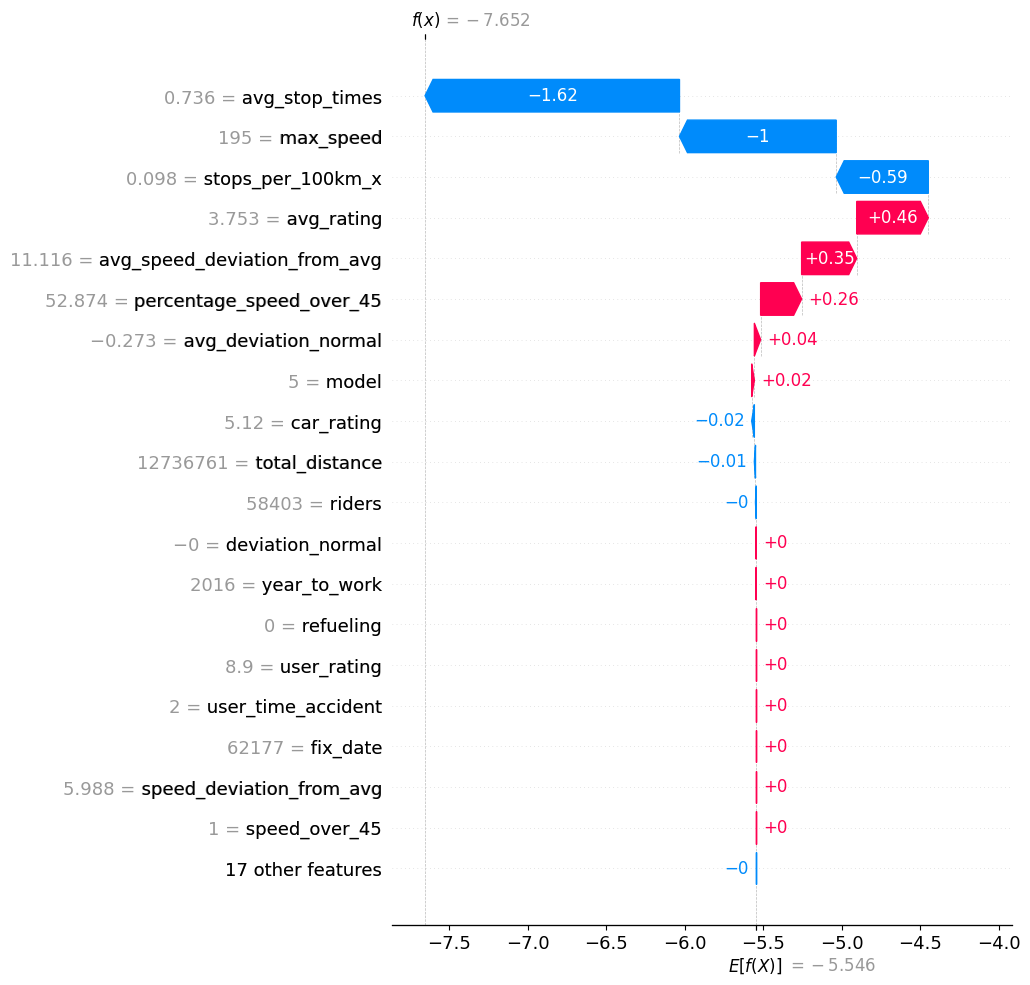

In [57]:
selected_observation = 0
selected_class = 0

# Получение SHAP-значений для выбранного наблюдения и класса
selected_shap_values = shap_values.values[selected_observation, :, selected_class]

# Получение значений признаков для выбранного наблюдения
selected_features = sample_X_test.iloc[selected_observation,:]

# Получение имён признаков
feature_names = sample_X_test.columns

# Построение диаграммы водопада
shap.waterfall_plot(shap.Explanation(values=selected_shap_values,
                                     base_values=explainer.expected_value[selected_class],
                                     data=selected_features.values,
                                     feature_names=feature_names), 
                    max_display=20)

P.S. Я пытался построить на полном наборе данных waterfall, но ядро постоянно умирало, в связи с чем был вынужден сделать подвыборку в 100000 наблюдений, для демонстрации работоспособности кода. 

## 3. Постройте classification_report из библиотеки scikit-learn.

In [30]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
# Построение classification report
report = classification_report(y_test, y_pred, target_names=model.classes_)
print(report)

                 precision    recall  f1-score   support

    another_bug       1.00      1.00      1.00    333363
      break_bug       1.00      1.00      1.00    322445
    electro_bug       1.00      1.00      1.00    297113
   engine_check       0.99      1.00      0.99    323555
    engine_fuel       0.94      0.87      0.90    313367
engine_ignition       0.89      0.97      0.93    322703
engine_overheat       0.88      0.86      0.87    345290
     gear_stick       1.00      1.00      1.00    339085
    wheel_shake       1.00      1.00      1.00    197171

       accuracy                           0.96   2794092
      macro avg       0.97      0.97      0.97   2794092
   weighted avg       0.96      0.96      0.96   2794092



## 4. Постройте и визуализируйте матрицу смежности (confusion_matrix), посмотрите, в каких классах модель больше всего ошибается.

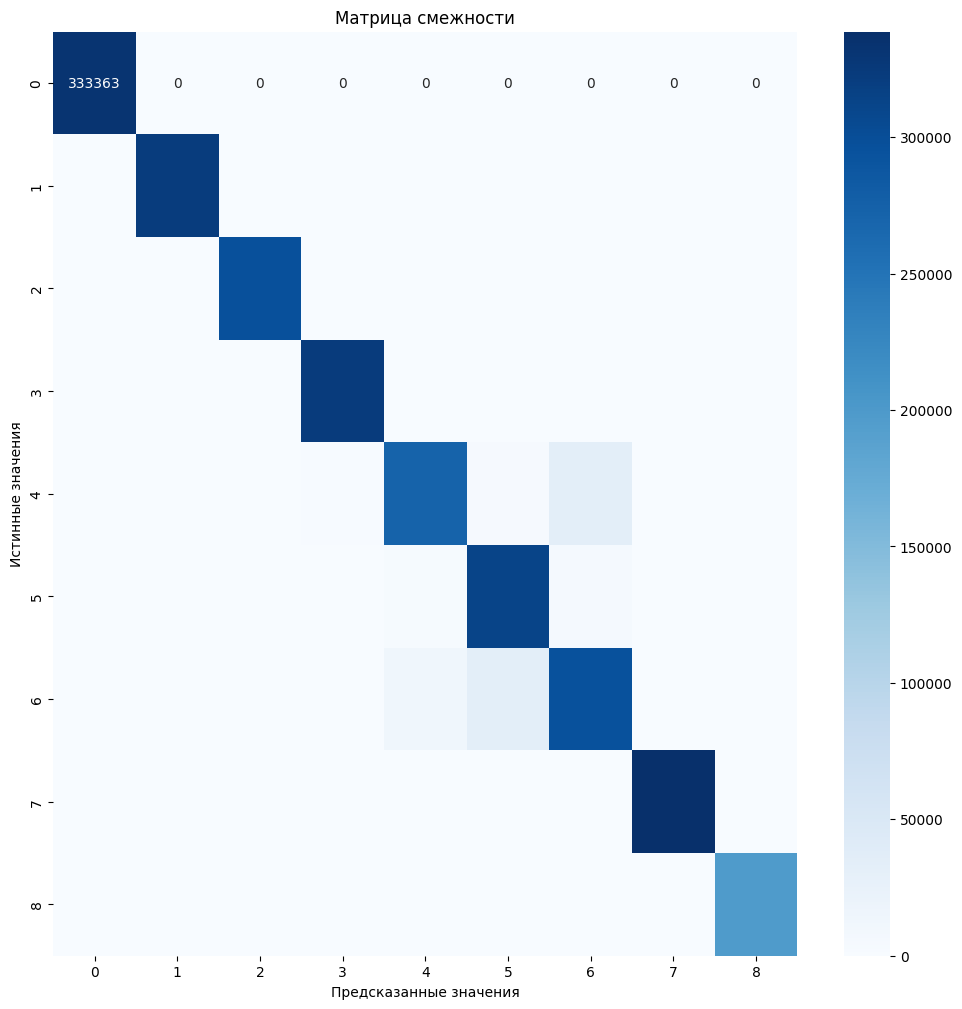

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Визуализация confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица смежности')
plt.show()

## 5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.

Итерации были проведены выше, а результаты получились следующие:
1. Из предоставленной матрицы смежности видно, что модель идеально предсказывает первые три и последние 2 класса. Классы же
`engine_check`, `engine_fuel`, `engine_ignition`, `engine_overheat`очень хорошо, но не на 100%
2. Перед итоговой моделью необходимо ислледовать наш таргет на дисбаланс классов, вероятнее всего именно из-за того что одного класса больше, чем другого и происходит переобучение модели
3. Необходимо поиграться с гиперпараметрами и попробовать подобрать более оптимальные под нашу задачу. 
4. Необходимо еще раз убедиться в том, что мы сделали корректный отбор признаков, возможно стоит какие-то признаки дропнуть, а какие-то наоборот добавить.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [64]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.